## Import

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F


from torchvision import transforms

In [2]:
import pandas as pd
import numpy as np

import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

## Preview

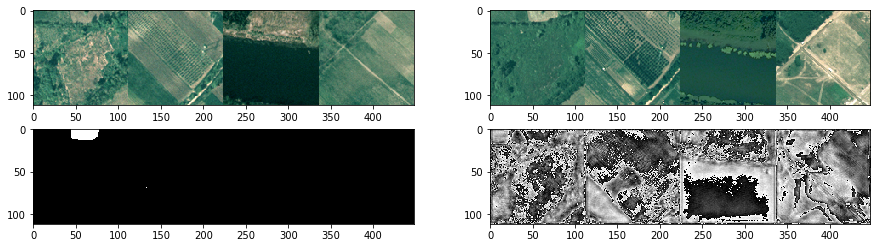

In [20]:
img1_path = 'C:/Users/ShiNian/Desktop/img1.png'
img2_path = 'C:/Users/ShiNian/Desktop/img2.png'
gt_path = 'C:/Users/ShiNian/Desktop/gt.png'
out_path = 'C:/Users/ShiNian/Desktop/output.png'


img1 = mpimg.imread(img1_path)
img2 = mpimg.imread(img2_path)
gt = mpimg.imread(gt_path)
gt[gt>0]=1
out = mpimg.imread(out_path)

plt.figure(figsize=(15,4))

plt.subplot(221)
plt.imshow(img1)
plt.subplot(222)
plt.imshow(img2)
plt.subplot(223)
plt.imshow(gt,cmap='gray')
plt.subplot(224)
plt.imshow(out)

plt.show()

In [23]:
mpimg.imsave(gt_path,gt)

## Input

In [4]:
data_transforms = transforms.Compose([
    transforms.ToTensor() # 转化为Tensor
])

x1 = data_transforms(img1)
x2 = data_transforms(img2)

## Model

In [5]:
class SiameseNet(nn.Module):
    def __init__(self):
        super(SiameseNet, self).__init__()
        self.featureExtract = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.Conv2d(64, 64, 5, padding=2),
            nn.Conv2d(64, 32, 5, padding=2),
            nn.Conv2d(32, 16, 1, padding=0),
        )
        

    def forward(self,x1,x2):
        x1 = self.featureExtract(x1)
        x2 = self.featureExtract(x2)        
        x = F.pairwise_distance(x1,x2,p=2)
        
        return x

## Output

In [83]:
data = pd.read_csv('./data.csv')
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')
data.shape[0]

3888

In [1]:
# %load test.py
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import torchvision
from torchvision import transforms

import matplotlib.pylab as plt
import numpy as np

from models import SiameseNet
from data_loader import myData
from configs import Config
from utils import log

log = log('./log.log')

cf = Config()
batch_size = cf.batch_size
num_epochs = cf.num_epochs
num_workers = cf.num_workers
leaning_rate = cf.learning_rate
momentum = cf.momentum
weight_decay = cf.weight_decay
show_every = cf.show_every
save_every = cf.save_every
test_every = cf.test_every
save_path = cf.save_path

test_batch = 156  # 100 or 200
test_epoch = 100

model_name = '{}Siamese-BCELoss-epoch-{}-batch-{}.pt'.format(
    save_path, test_batch, test_epoch)

log.info(model_name)

net = SiameseNet().to('cuda:0')
net.load_state_dict(torch.load(model_name))
net.eval()

myTransform = transforms.Compose([
    transforms.ToTensor()
])

testSet = myData(dataPath='./test.csv',
                 transform=myTransform)
testLoader = DataLoader(dataset=testSet,
                        num_workers=num_workers,
                        shuffle=False,
                        batch_size=batch_size)



In [2]:
if cf.use_gpu:
    device = torch.device("cuda:0")
    log.info(device)
    net = net.to(device)
    
def binaryImage(img):
#     print(img.size)
    img = np.array(img)
    print(img.shape)
    img[img>0]=255
    return img

deTransform = transforms.Compose([
    transforms.ToPILImage(),
])

(4, 112, 112) (4, 1, 112, 112)


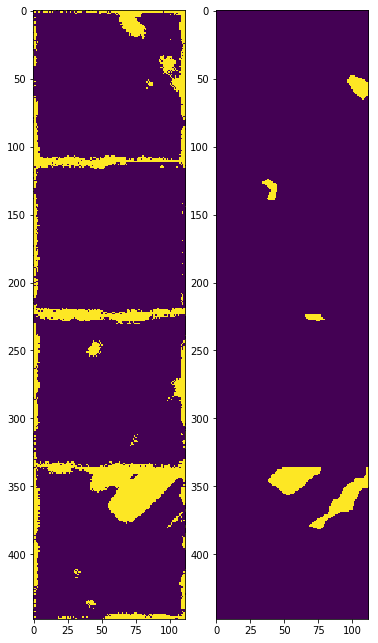

In [114]:
for batch, data in enumerate(testLoader, 1):
#     img1, img2, gt, gt_name = data[0].to(device), data[1].to(
#         device), data[2].to(device), data[3]
#     output = net(img1, img2)

#     bs,c,h,w = gt.shape
#     out_img = deTransform(output.reshape((1, 112, -1)).cpu())
#     gt_img = deTransform(gt.reshape((1, 112, -1)).cpu())

#     plt.subplot(211)
#     plt.imshow(out_img,cmap='gray')
#     plt.subplot(212)
#     plt.imshow(gt_img,cmap='gray')
#     plt.show()
#     print(gt_name)
    if batch == 41:
        img1, img2, gt, gt_name = data[0].to(device), data[1].to(
            device), data[2].to(device), data[3]
        output = net(img1, img2)
        
        np_out = output.detach().cpu().numpy()
        np_gt = gt.detach().cpu().numpy()
        
        m = 5e-4
        np_out[np_out>m]=255
        np_out[np_out<m]=0

        print(np_out.shape,np_gt.shape)
        plt.figure(figsize=(6,12))
        plt.subplot(121)
        plt.imshow(np_out.reshape((448,112)))
        plt.subplot(122)
        plt.imshow(np_gt.reshape((448,112)))
        plt.show()
        break

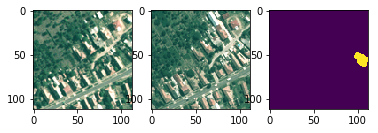

In [115]:
img1 = gt_name[0].replace('gt','img1').replace('GT','')
img1 = plt.imread(img1)
img2 = gt_name[0].replace('gt','img2').replace('GT','')
img2 = plt.imread(img2)
GT = plt.imread(gt_name[0])
plt.subplot(131)
plt.imshow(img1)
plt.subplot(132)
plt.imshow(img2)
plt.subplot(133)
plt.imshow(GT)


In [ ]:
gt_name[0].replace

In [ ]:
gt_name[0].replace

In [ ]:
gt_name[0].replace

## 自定义损失函数

In [86]:
x1 = np.random.randint(0,2,size=(8,112,112))
x2 = np.random.rand(8,112,112)

z1 = np.random.randint(0,2,size=(8,112,112))
z2 = np.random.rand(8,112,112)

x1 = torch.tensor(x1).to('cuda')
x2 = torch.tensor(x2).to('cuda')

class loss(nn.Module):
    def __init__(self):
        super(loss, self).__init__()

    def forward(self, D, Y):
        loss = 0.0
        m = 1  # 可能设置为一个可以学习的参数
        D = D.cpu().detach().numpy()
        Y = Y.cpu().detach().numpy()
        f_c = Y.sum()/Y.size
        w_u = 0.5/(1-f_c)
        w_c = 0.5/f_c
        loss = np.sum(Y*pow(np.maximum(0, m-D), 2)*w_c + (1-Y)*pow(D, 2)*w_u) / 2

        return torch.tensor(loss, requires_grad=True)

# from models import loss

criterion = loss()
output = criterion(x2,x1)
print(output.shape,output)
output.backward()

torch.Size([]) tensor(16755.2930, requires_grad=True)


## 原论文结构

In [4]:
# %load xqf/codefromfrance/siamunet_conc.py
# Rodrigo Caye Daudt
# https://rcdaudt.github.io/
# Daudt, R. C., Le Saux, B., & Boulch, A. "Fully convolutional siamese networks for change detection". In 2018 25th IEEE International Conference on Image Processing (ICIP) (pp. 4063-4067). IEEE.

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.modules.padding import ReplicationPad2d

class SiamUnet_conc(nn.Module):
    """SiamUnet_conc segmentation network."""

    def __init__(self, input_nbr, label_nbr):
        super(SiamUnet_conc, self).__init__()

        self.input_nbr = input_nbr

        self.conv11 = nn.Conv2d(input_nbr, 16, kernel_size=3, padding=1)
        self.bn11 = nn.BatchNorm2d(16)
        self.do11 = nn.Dropout2d(p=0.2)
        self.conv12 = nn.Conv2d(16, 16, kernel_size=3, padding=1)
        self.bn12 = nn.BatchNorm2d(16)
        self.do12 = nn.Dropout2d(p=0.2)

        self.conv21 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn21 = nn.BatchNorm2d(32)
        self.do21 = nn.Dropout2d(p=0.2)
        self.conv22 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.bn22 = nn.BatchNorm2d(32)
        self.do22 = nn.Dropout2d(p=0.2)

        self.conv31 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn31 = nn.BatchNorm2d(64)
        self.do31 = nn.Dropout2d(p=0.2)
        self.conv32 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn32 = nn.BatchNorm2d(64)
        self.do32 = nn.Dropout2d(p=0.2)
        self.conv33 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn33 = nn.BatchNorm2d(64)
        self.do33 = nn.Dropout2d(p=0.2)

        self.conv41 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn41 = nn.BatchNorm2d(128)
        self.do41 = nn.Dropout2d(p=0.2)
        self.conv42 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn42 = nn.BatchNorm2d(128)
        self.do42 = nn.Dropout2d(p=0.2)
        self.conv43 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn43 = nn.BatchNorm2d(128)
        self.do43 = nn.Dropout2d(p=0.2)

        self.upconv4 = nn.ConvTranspose2d(128, 128, kernel_size=3, padding=1, stride=2, output_padding=1)

        self.conv43d = nn.ConvTranspose2d(384, 128, kernel_size=3, padding=1)
        self.bn43d = nn.BatchNorm2d(128)
        self.do43d = nn.Dropout2d(p=0.2)
        self.conv42d = nn.ConvTranspose2d(128, 128, kernel_size=3, padding=1)
        self.bn42d = nn.BatchNorm2d(128)
        self.do42d = nn.Dropout2d(p=0.2)
        self.conv41d = nn.ConvTranspose2d(128, 64, kernel_size=3, padding=1)
        self.bn41d = nn.BatchNorm2d(64)
        self.do41d = nn.Dropout2d(p=0.2)

        self.upconv3 = nn.ConvTranspose2d(64, 64, kernel_size=3, padding=1, stride=2, output_padding=1)

        self.conv33d = nn.ConvTranspose2d(192, 64, kernel_size=3, padding=1)
        self.bn33d = nn.BatchNorm2d(64)
        self.do33d = nn.Dropout2d(p=0.2)
        self.conv32d = nn.ConvTranspose2d(64, 64, kernel_size=3, padding=1)
        self.bn32d = nn.BatchNorm2d(64)
        self.do32d = nn.Dropout2d(p=0.2)
        self.conv31d = nn.ConvTranspose2d(64, 32, kernel_size=3, padding=1)
        self.bn31d = nn.BatchNorm2d(32)
        self.do31d = nn.Dropout2d(p=0.2)

        self.upconv2 = nn.ConvTranspose2d(32, 32, kernel_size=3, padding=1, stride=2, output_padding=1)

        self.conv22d = nn.ConvTranspose2d(96, 32, kernel_size=3, padding=1)
        self.bn22d = nn.BatchNorm2d(32)
        self.do22d = nn.Dropout2d(p=0.2)
        self.conv21d = nn.ConvTranspose2d(32, 16, kernel_size=3, padding=1)
        self.bn21d = nn.BatchNorm2d(16)
        self.do21d = nn.Dropout2d(p=0.2)

        self.upconv1 = nn.ConvTranspose2d(16, 16, kernel_size=3, padding=1, stride=2, output_padding=1)

        self.conv12d = nn.ConvTranspose2d(48, 16, kernel_size=3, padding=1)
        self.bn12d = nn.BatchNorm2d(16)
        self.do12d = nn.Dropout2d(p=0.2)
        self.conv11d = nn.ConvTranspose2d(16, label_nbr, kernel_size=3, padding=1)

        self.sm = nn.LogSoftmax(dim=1)

    def forward(self, x1, x2):

        """Forward method."""
        # Stage 1
        x11 = self.do11(F.relu(self.bn11(self.conv11(x1))))
        x12_1 = self.do12(F.relu(self.bn12(self.conv12(x11))))
        x1p = F.max_pool2d(x12_1, kernel_size=2, stride=2)


        # Stage 2
        x21 = self.do21(F.relu(self.bn21(self.conv21(x1p))))
        x22_1 = self.do22(F.relu(self.bn22(self.conv22(x21))))
        x2p = F.max_pool2d(x22_1, kernel_size=2, stride=2)

        # Stage 3
        x31 = self.do31(F.relu(self.bn31(self.conv31(x2p))))
        x32 = self.do32(F.relu(self.bn32(self.conv32(x31))))
        x33_1 = self.do33(F.relu(self.bn33(self.conv33(x32))))
        x3p = F.max_pool2d(x33_1, kernel_size=2, stride=2)

        # Stage 4
        x41 = self.do41(F.relu(self.bn41(self.conv41(x3p))))
        x42 = self.do42(F.relu(self.bn42(self.conv42(x41))))
        x43_1 = self.do43(F.relu(self.bn43(self.conv43(x42))))
        x4p = F.max_pool2d(x43_1, kernel_size=2, stride=2)


        ####################################################
        # Stage 1
        x11 = self.do11(F.relu(self.bn11(self.conv11(x2))))
        x12_2 = self.do12(F.relu(self.bn12(self.conv12(x11))))
        x1p = F.max_pool2d(x12_2, kernel_size=2, stride=2)

        # Stage 2
        x21 = self.do21(F.relu(self.bn21(self.conv21(x1p))))
        x22_2 = self.do22(F.relu(self.bn22(self.conv22(x21))))
        x2p = F.max_pool2d(x22_2, kernel_size=2, stride=2)

        # Stage 3
        x31 = self.do31(F.relu(self.bn31(self.conv31(x2p))))
        x32 = self.do32(F.relu(self.bn32(self.conv32(x31))))
        x33_2 = self.do33(F.relu(self.bn33(self.conv33(x32))))
        x3p = F.max_pool2d(x33_2, kernel_size=2, stride=2)

        # Stage 4
        x41 = self.do41(F.relu(self.bn41(self.conv41(x3p))))
        x42 = self.do42(F.relu(self.bn42(self.conv42(x41))))
        x43_2 = self.do43(F.relu(self.bn43(self.conv43(x42))))
        x4p = F.max_pool2d(x43_2, kernel_size=2, stride=2)


        ####################################################
        # Stage 4d
        x4d = self.upconv4(x4p)
        pad4 = ReplicationPad2d((0, x43_1.size(3) - x4d.size(3), 0, x43_1.size(2) - x4d.size(2)))
        x4d = torch.cat((pad4(x4d), x43_1, x43_2), 1)
        x43d = self.do43d(F.relu(self.bn43d(self.conv43d(x4d))))
        x42d = self.do42d(F.relu(self.bn42d(self.conv42d(x43d))))
        x41d = self.do41d(F.relu(self.bn41d(self.conv41d(x42d))))

        # Stage 3d
        x3d = self.upconv3(x41d)
        pad3 = ReplicationPad2d((0, x33_1.size(3) - x3d.size(3), 0, x33_1.size(2) - x3d.size(2)))
        x3d = torch.cat((pad3(x3d), x33_1, x33_2), 1)
        x33d = self.do33d(F.relu(self.bn33d(self.conv33d(x3d))))
        x32d = self.do32d(F.relu(self.bn32d(self.conv32d(x33d))))
        x31d = self.do31d(F.relu(self.bn31d(self.conv31d(x32d))))

        # Stage 2d
        x2d = self.upconv2(x31d)
        pad2 = ReplicationPad2d((0, x22_1.size(3) - x2d.size(3), 0, x22_1.size(2) - x2d.size(2)))
        x2d = torch.cat((pad2(x2d), x22_1, x22_2), 1)
        x22d = self.do22d(F.relu(self.bn22d(self.conv22d(x2d))))
        x21d = self.do21d(F.relu(self.bn21d(self.conv21d(x22d))))

        # Stage 1d
        x1d = self.upconv1(x21d)
        pad1 = ReplicationPad2d((0, x12_1.size(3) - x1d.size(3), 0, x12_1.size(2) - x1d.size(2)))
        x1d = torch.cat((pad1(x1d), x12_1, x12_2), 1)
        x12d = self.do12d(F.relu(self.bn12d(self.conv12d(x1d))))
        x11d = self.conv11d(x12d)

        return self.sm(x11d)

In [5]:
# %load xqf/codefromfrance/siamunet_diff.py
# Rodrigo Caye Daudt
# https://rcdaudt.github.io/
# Daudt, R. C., Le Saux, B., & Boulch, A. "Fully convolutional siamese networks for change detection". In 2018 25th IEEE International Conference on Image Processing (ICIP) (pp. 4063-4067). IEEE.

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.modules.padding import ReplicationPad2d

class SiamUnet_diff(nn.Module):
    """SiamUnet_diff segmentation network."""

    def __init__(self, input_nbr, label_nbr):
        super(SiamUnet_diff, self).__init__()

        self.input_nbr = input_nbr

        self.conv11 = nn.Conv2d(input_nbr, 16, kernel_size=3, padding=1)
        self.bn11 = nn.BatchNorm2d(16)
        self.do11 = nn.Dropout2d(p=0.2)
        self.conv12 = nn.Conv2d(16, 16, kernel_size=3, padding=1)
        self.bn12 = nn.BatchNorm2d(16)
        self.do12 = nn.Dropout2d(p=0.2)

        self.conv21 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn21 = nn.BatchNorm2d(32)
        self.do21 = nn.Dropout2d(p=0.2)
        self.conv22 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.bn22 = nn.BatchNorm2d(32)
        self.do22 = nn.Dropout2d(p=0.2)

        self.conv31 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn31 = nn.BatchNorm2d(64)
        self.do31 = nn.Dropout2d(p=0.2)
        self.conv32 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn32 = nn.BatchNorm2d(64)
        self.do32 = nn.Dropout2d(p=0.2)
        self.conv33 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn33 = nn.BatchNorm2d(64)
        self.do33 = nn.Dropout2d(p=0.2)

        self.conv41 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn41 = nn.BatchNorm2d(128)
        self.do41 = nn.Dropout2d(p=0.2)
        self.conv42 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn42 = nn.BatchNorm2d(128)
        self.do42 = nn.Dropout2d(p=0.2)
        self.conv43 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn43 = nn.BatchNorm2d(128)
        self.do43 = nn.Dropout2d(p=0.2)

        self.upconv4 = nn.ConvTranspose2d(128, 128, kernel_size=3, padding=1, stride=2, output_padding=1)

        self.conv43d = nn.ConvTranspose2d(256, 128, kernel_size=3, padding=1)
        self.bn43d = nn.BatchNorm2d(128)
        self.do43d = nn.Dropout2d(p=0.2)
        self.conv42d = nn.ConvTranspose2d(128, 128, kernel_size=3, padding=1)
        self.bn42d = nn.BatchNorm2d(128)
        self.do42d = nn.Dropout2d(p=0.2)
        self.conv41d = nn.ConvTranspose2d(128, 64, kernel_size=3, padding=1)
        self.bn41d = nn.BatchNorm2d(64)
        self.do41d = nn.Dropout2d(p=0.2)

        self.upconv3 = nn.ConvTranspose2d(64, 64, kernel_size=3, padding=1, stride=2, output_padding=1)

        self.conv33d = nn.ConvTranspose2d(128, 64, kernel_size=3, padding=1)
        self.bn33d = nn.BatchNorm2d(64)
        self.do33d = nn.Dropout2d(p=0.2)
        self.conv32d = nn.ConvTranspose2d(64, 64, kernel_size=3, padding=1)
        self.bn32d = nn.BatchNorm2d(64)
        self.do32d = nn.Dropout2d(p=0.2)
        self.conv31d = nn.ConvTranspose2d(64, 32, kernel_size=3, padding=1)
        self.bn31d = nn.BatchNorm2d(32)
        self.do31d = nn.Dropout2d(p=0.2)

        self.upconv2 = nn.ConvTranspose2d(32, 32, kernel_size=3, padding=1, stride=2, output_padding=1)

        self.conv22d = nn.ConvTranspose2d(64, 32, kernel_size=3, padding=1)
        self.bn22d = nn.BatchNorm2d(32)
        self.do22d = nn.Dropout2d(p=0.2)
        self.conv21d = nn.ConvTranspose2d(32, 16, kernel_size=3, padding=1)
        self.bn21d = nn.BatchNorm2d(16)
        self.do21d = nn.Dropout2d(p=0.2)

        self.upconv1 = nn.ConvTranspose2d(16, 16, kernel_size=3, padding=1, stride=2, output_padding=1)

        self.conv12d = nn.ConvTranspose2d(32, 16, kernel_size=3, padding=1)
        self.bn12d = nn.BatchNorm2d(16)
        self.do12d = nn.Dropout2d(p=0.2)
        self.conv11d = nn.ConvTranspose2d(16, label_nbr, kernel_size=3, padding=1)

        self.sm = nn.LogSoftmax(dim=1)

    def forward(self, x1, x2):


        """Forward method."""
        # Stage 1
        x11 = self.do11(F.relu(self.bn11(self.conv11(x1))))
        x12_1 = self.do12(F.relu(self.bn12(self.conv12(x11))))
        x1p = F.max_pool2d(x12_1, kernel_size=2, stride=2)


        # Stage 2
        x21 = self.do21(F.relu(self.bn21(self.conv21(x1p))))
        x22_1 = self.do22(F.relu(self.bn22(self.conv22(x21))))
        x2p = F.max_pool2d(x22_1, kernel_size=2, stride=2)

        # Stage 3
        x31 = self.do31(F.relu(self.bn31(self.conv31(x2p))))
        x32 = self.do32(F.relu(self.bn32(self.conv32(x31))))
        x33_1 = self.do33(F.relu(self.bn33(self.conv33(x32))))
        x3p = F.max_pool2d(x33_1, kernel_size=2, stride=2)

        # Stage 4
        x41 = self.do41(F.relu(self.bn41(self.conv41(x3p))))
        x42 = self.do42(F.relu(self.bn42(self.conv42(x41))))
        x43_1 = self.do43(F.relu(self.bn43(self.conv43(x42))))
        x4p = F.max_pool2d(x43_1, kernel_size=2, stride=2)

        ####################################################
        # Stage 1
        x11 = self.do11(F.relu(self.bn11(self.conv11(x2))))
        x12_2 = self.do12(F.relu(self.bn12(self.conv12(x11))))
        x1p = F.max_pool2d(x12_2, kernel_size=2, stride=2)


        # Stage 2
        x21 = self.do21(F.relu(self.bn21(self.conv21(x1p))))
        x22_2 = self.do22(F.relu(self.bn22(self.conv22(x21))))
        x2p = F.max_pool2d(x22_2, kernel_size=2, stride=2)

        # Stage 3
        x31 = self.do31(F.relu(self.bn31(self.conv31(x2p))))
        x32 = self.do32(F.relu(self.bn32(self.conv32(x31))))
        x33_2 = self.do33(F.relu(self.bn33(self.conv33(x32))))
        x3p = F.max_pool2d(x33_2, kernel_size=2, stride=2)

        # Stage 4
        x41 = self.do41(F.relu(self.bn41(self.conv41(x3p))))
        x42 = self.do42(F.relu(self.bn42(self.conv42(x41))))
        x43_2 = self.do43(F.relu(self.bn43(self.conv43(x42))))
        x4p = F.max_pool2d(x43_2, kernel_size=2, stride=2)



        # Stage 4d
        x4d = self.upconv4(x4p)
        pad4 = ReplicationPad2d((0, x43_1.size(3) - x4d.size(3), 0, x43_1.size(2) - x4d.size(2)))
        x4d = torch.cat((pad4(x4d), torch.abs(x43_1 - x43_2)), 1)
        x43d = self.do43d(F.relu(self.bn43d(self.conv43d(x4d))))
        x42d = self.do42d(F.relu(self.bn42d(self.conv42d(x43d))))
        x41d = self.do41d(F.relu(self.bn41d(self.conv41d(x42d))))

        # Stage 3d
        x3d = self.upconv3(x41d)
        pad3 = ReplicationPad2d((0, x33_1.size(3) - x3d.size(3), 0, x33_1.size(2) - x3d.size(2)))
        x3d = torch.cat((pad3(x3d), torch.abs(x33_1 - x33_2)), 1)
        x33d = self.do33d(F.relu(self.bn33d(self.conv33d(x3d))))
        x32d = self.do32d(F.relu(self.bn32d(self.conv32d(x33d))))
        x31d = self.do31d(F.relu(self.bn31d(self.conv31d(x32d))))

        # Stage 2d
        x2d = self.upconv2(x31d)
        pad2 = ReplicationPad2d((0, x22_1.size(3) - x2d.size(3), 0, x22_1.size(2) - x2d.size(2)))
        x2d = torch.cat((pad2(x2d), torch.abs(x22_1 - x22_2)), 1)
        x22d = self.do22d(F.relu(self.bn22d(self.conv22d(x2d))))
        x21d = self.do21d(F.relu(self.bn21d(self.conv21d(x22d))))

        # Stage 1d
        x1d = self.upconv1(x21d)
        pad1 = ReplicationPad2d((0, x12_1.size(3) - x1d.size(3), 0, x12_1.size(2) - x1d.size(2)))
        x1d = torch.cat((pad1(x1d), torch.abs(x12_1 - x12_2)), 1)
        x12d = self.do12d(F.relu(self.bn12d(self.conv12d(x1d))))
        x11d = self.conv11d(x12d)

        return self.sm(x11d)
   


In [6]:
# %load xqf/codefromfrance/unet.py
# Rodrigo Caye Daudt
# https://rcdaudt.github.io/
# Daudt, R. C., Le Saux, B., & Boulch, A. "Fully convolutional siamese networks for change detection". In 2018 25th IEEE International Conference on Image Processing (ICIP) (pp. 4063-4067). IEEE.

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.modules.padding import ReplicationPad2d

class Unet(nn.Module):
    """EF segmentation network."""

    def __init__(self, input_nbr, label_nbr):
        super(Unet, self).__init__()

        self.input_nbr = input_nbr

        self.conv11 = nn.Conv2d(input_nbr, 16, kernel_size=3, padding=1)
        self.bn11 = nn.BatchNorm2d(16)
        self.do11 = nn.Dropout2d(p=0.2)
        self.conv12 = nn.Conv2d(16, 16, kernel_size=3, padding=1)
        self.bn12 = nn.BatchNorm2d(16)
        self.do12 = nn.Dropout2d(p=0.2)

        self.conv21 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn21 = nn.BatchNorm2d(32)
        self.do21 = nn.Dropout2d(p=0.2)
        self.conv22 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.bn22 = nn.BatchNorm2d(32)
        self.do22 = nn.Dropout2d(p=0.2)

        self.conv31 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn31 = nn.BatchNorm2d(64)
        self.do31 = nn.Dropout2d(p=0.2)
        self.conv32 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn32 = nn.BatchNorm2d(64)
        self.do32 = nn.Dropout2d(p=0.2)
        self.conv33 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn33 = nn.BatchNorm2d(64)
        self.do33 = nn.Dropout2d(p=0.2)

        self.conv41 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn41 = nn.BatchNorm2d(128)
        self.do41 = nn.Dropout2d(p=0.2)
        self.conv42 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn42 = nn.BatchNorm2d(128)
        self.do42 = nn.Dropout2d(p=0.2)
        self.conv43 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn43 = nn.BatchNorm2d(128)
        self.do43 = nn.Dropout2d(p=0.2)


        self.upconv4 = nn.ConvTranspose2d(128, 128, kernel_size=3, padding=1, stride=2, output_padding=1)

        self.conv43d = nn.ConvTranspose2d(256, 128, kernel_size=3, padding=1)
        self.bn43d = nn.BatchNorm2d(128)
        self.do43d = nn.Dropout2d(p=0.2)
        self.conv42d = nn.ConvTranspose2d(128, 128, kernel_size=3, padding=1)
        self.bn42d = nn.BatchNorm2d(128)
        self.do42d = nn.Dropout2d(p=0.2)
        self.conv41d = nn.ConvTranspose2d(128, 64, kernel_size=3, padding=1)
        self.bn41d = nn.BatchNorm2d(64)
        self.do41d = nn.Dropout2d(p=0.2)

        self.upconv3 = nn.ConvTranspose2d(64, 64, kernel_size=3, padding=1, stride=2, output_padding=1)

        self.conv33d = nn.ConvTranspose2d(128, 64, kernel_size=3, padding=1)
        self.bn33d = nn.BatchNorm2d(64)
        self.do33d = nn.Dropout2d(p=0.2)
        self.conv32d = nn.ConvTranspose2d(64, 64, kernel_size=3, padding=1)
        self.bn32d = nn.BatchNorm2d(64)
        self.do32d = nn.Dropout2d(p=0.2)
        self.conv31d = nn.ConvTranspose2d(64, 32, kernel_size=3, padding=1)
        self.bn31d = nn.BatchNorm2d(32)
        self.do31d = nn.Dropout2d(p=0.2)

        self.upconv2 = nn.ConvTranspose2d(32, 32, kernel_size=3, padding=1, stride=2, output_padding=1)

        self.conv22d = nn.ConvTranspose2d(64, 32, kernel_size=3, padding=1)
        self.bn22d = nn.BatchNorm2d(32)
        self.do22d = nn.Dropout2d(p=0.2)
        self.conv21d = nn.ConvTranspose2d(32, 16, kernel_size=3, padding=1)
        self.bn21d = nn.BatchNorm2d(16)
        self.do21d = nn.Dropout2d(p=0.2)

        self.upconv1 = nn.ConvTranspose2d(16, 16, kernel_size=3, padding=1, stride=2, output_padding=1)

        self.conv12d = nn.ConvTranspose2d(32, 16, kernel_size=3, padding=1)
        self.bn12d = nn.BatchNorm2d(16)
        self.do12d = nn.Dropout2d(p=0.2)
        self.conv11d = nn.ConvTranspose2d(16, label_nbr, kernel_size=3, padding=1)

        self.sm = nn.LogSoftmax(dim=1)

    def forward(self, x1, x2):

        x = torch.cat((x1, x2), 1)

        """Forward method."""
        # Stage 1
        x11 = self.do11(F.relu(self.bn11(self.conv11(x))))
        x12 = self.do12(F.relu(self.bn12(self.conv12(x11))))
        x1p = F.max_pool2d(x12, kernel_size=2, stride=2)

        # Stage 2
        x21 = self.do21(F.relu(self.bn21(self.conv21(x1p))))
        x22 = self.do22(F.relu(self.bn22(self.conv22(x21))))
        x2p = F.max_pool2d(x22, kernel_size=2, stride=2)

        # Stage 3
        x31 = self.do31(F.relu(self.bn31(self.conv31(x2p))))
        x32 = self.do32(F.relu(self.bn32(self.conv32(x31))))
        x33 = self.do33(F.relu(self.bn33(self.conv33(x32))))
        x3p = F.max_pool2d(x33, kernel_size=2, stride=2)

        # Stage 4
        x41 = self.do41(F.relu(self.bn41(self.conv41(x3p))))
        x42 = self.do42(F.relu(self.bn42(self.conv42(x41))))
        x43 = self.do43(F.relu(self.bn43(self.conv43(x42))))
        x4p = F.max_pool2d(x43, kernel_size=2, stride=2)


        # Stage 4d
        x4d = self.upconv4(x4p)
        pad4 = ReplicationPad2d((0, x43.size(3) - x4d.size(3), 0, x43.size(2) - x4d.size(2)))
        x4d = torch.cat((pad4(x4d), x43), 1)
        x43d = self.do43d(F.relu(self.bn43d(self.conv43d(x4d))))
        x42d = self.do42d(F.relu(self.bn42d(self.conv42d(x43d))))
        x41d = self.do41d(F.relu(self.bn41d(self.conv41d(x42d))))

        # Stage 3d
        x3d = self.upconv3(x41d)
        pad3 = ReplicationPad2d((0, x33.size(3) - x3d.size(3), 0, x33.size(2) - x3d.size(2)))
        x3d = torch.cat((pad3(x3d), x33), 1)
        x33d = self.do33d(F.relu(self.bn33d(self.conv33d(x3d))))
        x32d = self.do32d(F.relu(self.bn32d(self.conv32d(x33d))))
        x31d = self.do31d(F.relu(self.bn31d(self.conv31d(x32d))))

        # Stage 2d
        x2d = self.upconv2(x31d)
        pad2 = ReplicationPad2d((0, x22.size(3) - x2d.size(3), 0, x22.size(2) - x2d.size(2)))
        x2d = torch.cat((pad2(x2d), x22), 1)
        x22d = self.do22d(F.relu(self.bn22d(self.conv22d(x2d))))
        x21d = self.do21d(F.relu(self.bn21d(self.conv21d(x22d))))

        # Stage 1d
        x1d = self.upconv1(x21d)
        pad1 = ReplicationPad2d((0, x12.size(3) - x1d.size(3), 0, x12.size(2) - x1d.size(2)))
        x1d = torch.cat((pad1(x1d), x12), 1)
        x12d = self.do12d(F.relu(self.bn12d(self.conv12d(x1d))))
        x11d = self.conv11d(x12d)

        return self.sm(x11d)


In [9]:
m = nn.LogSoftmax()
input = torch.randn(2, 3)
output = m(input)
output

d:\office\office\python\python3.6.2\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until


tensor([[-0.9661, -0.8067, -1.7540],
        [-0.7558, -0.8359, -2.3342]])